# Fit Hindmars Rose into HH model noisy traces

In [1]:
import pandas as pd
import numpy as np

In [2]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Setup Parametrs

In [3]:
dt = 0.01*ms
defaultclock.dt = dt

### Load Input and Output

In [4]:
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

In [5]:
inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[1:3, 1:]
inp_traces

array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e-09, 2.e-09, 2.e-09, ..., 0.e+00, 0.e+00, 0.e+00]])

In [6]:
out_traces = df_out_traces.to_numpy()
out_traces = out_traces[1:3, 1:]
out_traces

array([[-63.78548155, -64.75587972, -64.60550311, ..., -64.42127691,
        -65.13069593, -64.48718384],
       [-62.92648395, -65.82540807, -64.76394825, ..., -64.9418292 ,
        -63.8704734 , -63.17105741]])

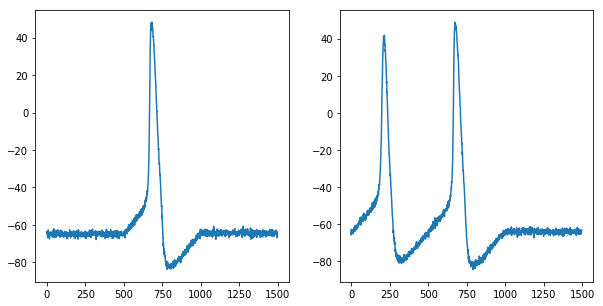

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(out_traces[0])
ax[1].plot(out_traces[1]);

# Model Fitting 

In [8]:
eqs = Equations('''
dx/dt = (y - a*x**3 + b*x**2 + 3 * I/nA - z)/time_unit : 1
dy/dt = (c - d*x**2 - y)/time_unit : 1
dz/dt = r*(s*(x - x_1) - z)/time_unit : 1
v = (base + x * scale) * mV :volt
base: 1 (constant)
scale: 1 (constant)
a: 1 (constant)
b: 1 (constant)
c: 1 (constant)
d: 1 (constant)
r: 1 (constant)
s: 1 (constant)
x_1: 1 (constant)
''',
time_unit=1*ms
               )

In [9]:
start_scope()
n_opt = NevergradOptimizer(method='TwoPointsDE')
metric = MSEMetric()

In [10]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [14]:
res, error = fit_traces(model=eqs, input_var='I', output_var='v',
                       input=inp_traces * amp, output=out_traces*mV, dt=dt,
                       method='rk4',
                       callback=callback,
                       scale = [10, 50], 
                       base = [-30, 0],
                       a = [0, 20],
                       b = [0, 20],
                       c = [0, 20],
                       d = [0, 20],
                       r = [0.0001, 0.01],
                       s = [0, 10],
                       x_1 = [-5, 5],
                       param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                       n_rounds=100, n_samples=30, optimizer=n_opt, metric=metric
                       )

res

index 0 errors minimum: 4.687393768251411
index 1 errors minimum: 3.6326516245052574
index 2 errors minimum: 3.371085373532263
index 3 errors minimum: 2.203190119351921
index 4 errors minimum: 2.1633886393723145
index 5 errors minimum: 2.5996523506156253
index 6 errors minimum: 1.9325627178045905
index 7 errors minimum: 1.2758211340187766
index 8 errors minimum: 1.270970225356769
index 9 errors minimum: 1.5363818255072568
index 10 errors minimum: 0.9722138233565165
index 11 errors minimum: 1.0221380996642888
index 12 errors minimum: 1.0396558251963277
index 13 errors minimum: 0.7703863347319835
index 14 errors minimum: 1.3196450282357928
index 15 errors minimum: 0.7717780173652278
index 16 errors minimum: 0.7683671494946119
index 17 errors minimum: 0.847517915113273
index 18 errors minimum: 0.8456237119564487
index 19 errors minimum: 1.064382419773692
index 20 errors minimum: 0.6993873907779085
index 21 errors minimum: 0.6993873907779085
index 22 errors minimum: 0.8390864293652561
inde

{'r': 0.002004274690349309,
 's': 0.42346893832309984,
 'x_1': 4.948777963359355,
 'd': 17.941588272727245,
 'scale': 21.7258973294241,
 'a': 2.8216660176456436,
 'base': -28.631450894077688,
 'c': 0.9039617005145306,
 'b': 10.645759405027784}

## visualization of the results

In [15]:
start_scope()
fits = generate_fits(model=eqs, method='rk4', params=res,
                     input=inp_traces * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'x': -1.6, 'y':1 - 5*(-1.6)**2, 'z':0.001*(4*(-1.6 - -1.6))}, 
                    )

x = fits/mV

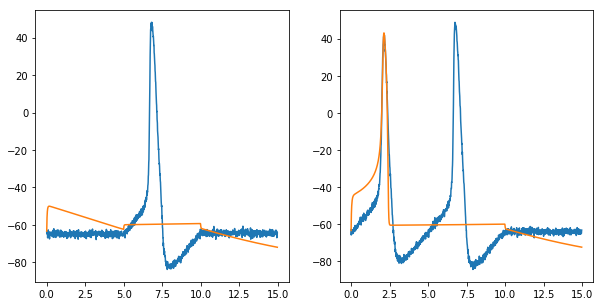

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(np.arange(len(out_traces[0]))*dt/ms, out_traces[0], label='goal');
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV, label='fit');
ax[1].plot(np.arange(len(out_traces[1]))*dt/ms, out_traces[1], label='goal');
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV, label='fit');